In [1]:
# %%

import sys
from pathlib import Path
import os
sys.path.append(str(Path.cwd().parent))
from pprint import pprint

# %%
# %%
# %%
import pyrootutils
# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)
from pprint import pprint

from pathlib import Path
import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm
import sys
from pathlib import Path

import torch.nn as nn
import hydra

import torch
import seaborn as sns
from omegaconf import OmegaConf
from pytorch_lightning import LightningModule

import src.utils.default as utils
sitk.ProcessObject_SetGlobalWarningDisplay(False)
from src.data.bvisa_dm import CS_Dataset

import matplotlib.pyplot as plt

from monai.metrics import compute_dice, compute_hausdorff_distance, compute_iou

import os
from src.data.splits import (bvisa_splits, bvisa_left_sulci_labels,
                             bvisa_right_sulci_labels, bvisa_padding_dims,
                             bad_via11, via11_qc)
from src.utils.general import crop_image_to_content, resample_volume
from src.utils.general import sitk_cropp_padd_img_to_size


# Compare the segmentation results of the different methods quantitatively with metrics DSC and HD

In [2]:
# from src.data.splits import (bvisa_splits, bvisa_left_sulci_labels,
#                              bvisa_right_sulci_labels, bvisa_padding_dims,
#                              bad_via11, via11_qc)
# from src.utils.general import crop_image_to_content, resample_volume
# from src.utils.general import sitk_cropp_padd_img_to_size


# class CS_eval_via(CS_Dataset):
#     def __init__(self,
#                  corrections_path: str,
#                  resample: list[float] | None = None,
#                  crop2content: bool = False,
#                  croppadd2same_size: str = None):
#         """Constructor for CS_Dataset class

#         Args:
#             corrections_path (str): Path to corrected segmentations.
#             resample (list[x, y, z] | None, optional): Resample the images to a given resolution.
#             crop2content (bool, optional): Crop the images to the content of the image.
#             padd2same_size (string, optional): Pad-cropps the images to the same size depending on image type.
#         """

#         # save dataset hyperparameters
#         self.corrections_path = Path(corrections_path)
#         self.resample = list(resample) if resample is not None else None
#         self.crop2content = crop2content
#         self.croppadd2same_size = croppadd2same_size
#         if self.croppadd2same_size:
#             self.cropPadd_size = [int(x) for x in croppadd2same_size.split('-')]
#         # load corresponding image and target paths
#         self.img_paths = []
#         self.target_paths = []
#         self.corrected_target_paths = []
#         self.caseids = []

#         self._load_via11_corrected()

#     def _load_via11_corrected(self):
#         """Load VIA11 dataset"""
#         drcmr_path = Path(os.environ.get('VIA11_DRCMR'))
#         cfin_path = Path(os.environ.get('VIA11_CFIN'))

#         cfin_subjs = [subj for subj in cfin_path.iterdir() if subj.is_dir()]
#         drcmr_subjs = [subj for subj in drcmr_path.iterdir() if subj.is_dir()]
#         all_subjs = cfin_subjs + drcmr_subjs
        
#         # filter only corrected subjects

#         cfin_corr = set([str(x.name).removeprefix('LSulci_').removeprefix('RSulci_')[:10] for x in (corrected_path/'CFIN').glob('*.nii.gz')])
#         drcmr_corr = set([str(x.name).removeprefix('LSulci_').removeprefix('RSulci_')[:10] for x in (corrected_path/'DRCMR').glob('*.nii.gz')])
#         all_corr = cfin_corr.union(drcmr_corr)
#         all_subjs = [subj for subj in all_subjs if subj.name in all_corr]
        
#         for subj in all_subjs:
#             self.__load_subject_via11(subj)


#     def __load_subject_via11(self, subj):
#         sulci_path = os.environ.get('SEGM_PATH')

#         # get image input paths
#         image_paths = []

#         image_paths.append(subj/f't1mri/default_acquisition/default_analysis/segmentation/skull_stripped_{subj.name}.nii.gz')

#         subj_id = subj.name
#         self.caseids.append(subj_id)
#         self.img_paths.append(image_paths)

#         # get target paths
#         target_paths = []
#         target_paths.append(subj/f'{sulci_path}/LSulci_{subj_id}_default_session_best.nii.gz')
#         target_paths.append(subj/f'{sulci_path}/RSulci_{subj_id}_default_session_best.nii.gz')
#         self.target_paths.append(target_paths)
        
#         # get corrected  target paths
#         corr_paths = []
        
#         pref = '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited'
#         center = str(target_paths[0]).split('BrainVisa/BrainVisa/')[1].split('/')[0]
#         subj = str(target_paths[0]).split(center)[1][1:11]
#         corrp_L = f'{pref}/{center}/LSulci_{subj}_default_session_best_edit_NHT.nii.gz'
#         corrp_R = f'{pref}/{center}/RSulci_{subj}_default_session_best_edit_NHT.nii.gz'
    
#         corr_paths.append(corrp_L)
#         corr_paths.append(corrp_R)
#         self.corrected_target_paths.append(corr_paths)
        

#     def _load_image_target(self, idx):
#         # load image
#         image = sitk.ReadImage(str(self.img_paths[idx][0]))
#         # reorient to RAS to have similar orientation as BVISA images
#         image = sitk.DICOMOrient(image, 'RAS')
        
#         # load target
#         ltarget = sitk.ReadImage(str(self.target_paths[idx][0]))
#         rtarget = sitk.ReadImage(str(self.target_paths[idx][1]))
#         target = sitk.Cast((ltarget + rtarget) > 0, sitk.sitkInt16)
#         # reorient to RAS to have similar orientation as BVISA images
#         target = sitk.DICOMOrient(target, 'RAS')

#         # load target
#         ltarget = sitk.ReadImage(str(self.corrected_target_paths[idx][0]))
#         rtarget = sitk.ReadImage(str(self.corrected_target_paths[idx][1]))
#         corr_target = sitk.Cast((ltarget + rtarget) > 0, sitk.sitkInt16)
#         # reorient to RAS to have similar orientation as BVISA images
#         corr_target = sitk.DICOMOrient(corr_target, 'RAS')
        
#         return image, target, corr_target

#     def __len__(self):
#         return len(self.img_paths)

#     def __getitem__(self, idx):
    
#         image, target, corr_target = self._load_image_target(idx)

#         # pre-process images
#         image, target, corr_target = self._preprocess(image, target, corr_target)

#         # post-process images
#         image, target, corr_target = self._postprocess(image, target, corr_target)

#         sample = {'image': image, 'target': target, 'corr_target': corr_target}

#         # get caseid
#         sample['caseid'] = self.caseids[idx]

#         return sample

#     def _preprocess(self, image, target, corr_target):
#         """Converts from sitk.Image to torch.Tensor and
#            ensures that targets have proper labels and
#            images are normalized.

#         Args:
#             image (sitk.Image): Input image.
#             target (sitk.Image): Target image.

#         Returns:
#             tuple(Tensor, Tensor): Pre-processed image and target.
#         """
#         # resample if needed
#         if self.resample is not None:
#             image_interpolator = sitk.sitkLinear
#             image = resample_volume(image, self.resample, image_interpolator)
#             target = resample_volume(target, self.resample,
#                                      interpolator=sitk.sitkNearestNeighbor)
#             corr_target = resample_volume(corr_target, self.resample,
#                                      interpolator=sitk.sitkNearestNeighbor)
        
#         # crop to content
#         if self.crop2content:
#             img2crop = sitk.GetArrayFromImage(image)
#             target2crop = sitk.GetArrayFromImage(target)
#             coorrtarget2crop = sitk.GetArrayFromImage(corr_target)
#             image, min_coords, max_coords = crop_image_to_content(img2crop)
#             target, _, __ = crop_image_to_content(target2crop, min_coords, max_coords)
#             corr_target, _, __ = crop_image_to_content(coorrtarget2crop, min_coords, max_coords)
#             image = sitk.GetImageFromArray(image)
#             target = sitk.GetImageFromArray(target)
#             corr_target = sitk.GetImageFromArray(corr_target)

#         if self.croppadd2same_size:
#             # cropp-padding if needed
#             image = sitk_cropp_padd_img_to_size(image, self.cropPadd_size)
#             target = sitk_cropp_padd_img_to_size(target, self.cropPadd_size)
#             corr_target = sitk_cropp_padd_img_to_size(corr_target, self.cropPadd_size)

#         # convert to numpy
#         image = sitk.GetArrayFromImage(image)
#         target = sitk.GetArrayFromImage(target)
#         corr_target = sitk.GetArrayFromImage(corr_target)


#         # min-max normalization of the image
#         image = (image - image.min()) / (image.max() - image.min())

#         return torch.Tensor(image), torch.tensor(target, dtype=torch.long), torch.tensor(corr_target, dtype=torch.long)

#     def _postprocess(self, image: torch.Tensor, target: torch.Tensor, corr_target):
#         # padd if needed
#         # TODO: FIX THE ERROR WITH THE ACTIVE PADDING
#         # if self.padd2same_size:
#         #     raise ValueError('Should not be used anymore')
#         #     size_key = 'original' if self.resample is None else str(self.resample)
#         #     pad_dims = bvisa_padding_dims[self.input][size_key]
#         #     padd = SpatialPad(pad_dims, mode='constant', value=0)
#         #     image = padd(torch.unsqueeze(image, dim=0))[0]
#         #     target = padd(torch.unsqueeze(target, dim=0))[0]

#         # add channel dimension to the image
#         image = torch.unsqueeze(image, 0)
#         return image, target, corr_target

In [3]:

# # %%
# CHKP = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/logs_finetuning/CS1x_via11SegmSST_monaiUnet-fullFinetune/runs/2023-05-24_11-16-51/checkpoints/epoch-253-Esubj-0.4463.ckpt')
# print(CHKP)
# out_path = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/skull_stripped_images')

# corrected_path = '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited'
# corrected_path = Path(corrected_path)
# exp_name = CHKP.parent.parent.parent.parent.name
# out_path = out_path / exp_name
# out_path.mkdir(exist_ok=True, parents=True)
# cgf_path = CHKP.parent.parent / '.hydra' / 'config.yaml'
# finetune_cfg = OmegaConf.load(cgf_path)

# segm_model: LightningModule = hydra.utils.instantiate(finetune_cfg.model)
# # sst_ds = hydra.utils.instantiate(finetune_cfg.data)
# # print(finetune_cfg.data)
# segm_model = segm_model.load_from_checkpoint(CHKP).to('cuda')
# segm_model = segm_model.eval()


# # %% [markdown]
# # # Load via validation images

# # %% USE ONLY FOR 1X DATASET
# finetune_cfg.data.dataset_cfg.resample = [1.1, 1.1, 1.5]


# # %%
# croppadd2same_size =  finetune_cfg.data.dataset_cfg.get('padd2same_size') if finetune_cfg.data.dataset_cfg.get('padd2same_size') else finetune_cfg.data.dataset_cfg.get('croppadd2same_size')

# # %%
# # via11DS = CS_Dataset('via11', 'mp2rage_skull_stripped',
# #                     'bvisa_CS', dataset_path='',
# #                      split='only_good',
# #                      crop2content=True,
# #                      preload=False,
# #                      resample=finetune_cfg.data.dataset_cfg.resample,
# #                      croppadd2same_size=croppadd2same_size)

# via11DS = CS_eval_via(corrected_path,
#                       resample=finetune_cfg.data.dataset_cfg.resample,
#                       croppadd2same_size=croppadd2same_size,
#                       crop2content=True,)

# # # %%
# # experiment_results = []
# # for idx in tqdm(range(len(via11DS))):
# #     sample = via11DS[idx]
# #     target_1hot = torch.nn.functional.one_hot(sample['target'].unsqueeze(0), num_classes=2).permute(0, 4, 1, 2, 3)
# #     corrected_target_1hot = torch.nn.functional.one_hot(sample['corr_target'].unsqueeze(0), num_classes=2).permute(0, 4, 1, 2, 3)
# #     with torch.no_grad():
# #         out = segm_model.forward(sample['image'].unsqueeze(0).to('cuda'))
# #     out_bin = torch.argmax(torch.softmax(out, dim=1), dim=1).cpu()
# #     out_1hot = torch.nn.functional.one_hot(out_bin, num_classes=2).permute(0, 4, 1, 2, 3)

# #     pred_dice = compute_dice(out_1hot, corrected_target_1hot, include_background=False)
# #     pred_iou = compute_iou(out_1hot, corrected_target_1hot, include_background=False)
# #     pred_hausdorff_distance = compute_hausdorff_distance(out_1hot, corrected_target_1hot,
# #                                                     include_background=False)

# #     bvisa_dice = compute_dice(target_1hot, corrected_target_1hot, include_background=False)
# #     bvisa_iou = compute_iou(target_1hot, corrected_target_1hot, include_background=False)
# #     bvisa_hausdorff_distance = compute_hausdorff_distance(target_1hot, corrected_target_1hot,
# #                                                     include_background=False)
    
# #     res = {'caseid': via11DS.caseids[idx],
# #             'bvisa_dice':bvisa_dice.item(),
# #             'bvisa_iou':bvisa_iou.item(),
# #             'bvisa_hausdorff_distance':bvisa_hausdorff_distance.item(),
# #             'bvisa_dice':bvisa_dice.item(),
# #             'bvisa_iou':bvisa_iou.item(),
# #             'bvisa_hausdorff_distance':bvisa_hausdorff_distance.item(),
# #            }
# #     experiment_results.append(res)
# # experiment_results = pd.DataFrame(experiment_results)
# # experiment_results = experiment_results.set_index('caseid')
# # experiment_results.loc['MEAN'] = experiment_results.mean()
# # experiment_results.loc['STD'] = experiment_results.std()
# # experiment_results.to_csv(f'{out_path}/via11_metrics.csv')

# # pprint(experiment_results)

In [4]:
# sitk.WriteImage(sitk.GetImageFromArray(s['image'].numpy()[0]), '/mrhome/vladyslavz/Pictures/tmp/img.nii.gz')
# sitk.WriteImage(sitk.GetImageFromArray(s['target'].numpy().astype(np.int16)), '/mrhome/vladyslavz/Pictures/tmp/target.nii.gz')
# sitk.WriteImage(sitk.GetImageFromArray(post_prcosess_segm(s['target'].numpy()).astype(np.int16)), '/mrhome/vladyslavz/Pictures/tmp/target_post.nii.gz')
# sitk.WriteImage(sitk.GetImageFromArray(s['corr_target'].numpy().astype(np.int16)), '/mrhome/vladyslavz/Pictures/tmp/corr_target.nii.gz')

In [2]:
df = '/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/skull_stripped_images/CS1x_via11SegmSST_monaiUnet-fullFinetune'

df = pd.read_csv(df+'/corr_via11_metrics.csv', index_col=0)
df = df.rename(columns={'bvisa_dice':'BrainVISA DSC', 'pred_dice':'SST-MT DSC',
                   'bvisa_hausdorff_distance':'BrainVISA HD', 'pred_hausdorff_distance':'SST-MT HD'})
df = df.loc[df.index.values[:-2]]
df = df[~df.index.isin(['sub-via305', 'sub-via311'])]

In [3]:
sns.set_palette("muted")
plt.rcParams['font.size']  = 25
sns.set_context("notebook", font_scale=1.5)


2023-05-26 14:07:36,655 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


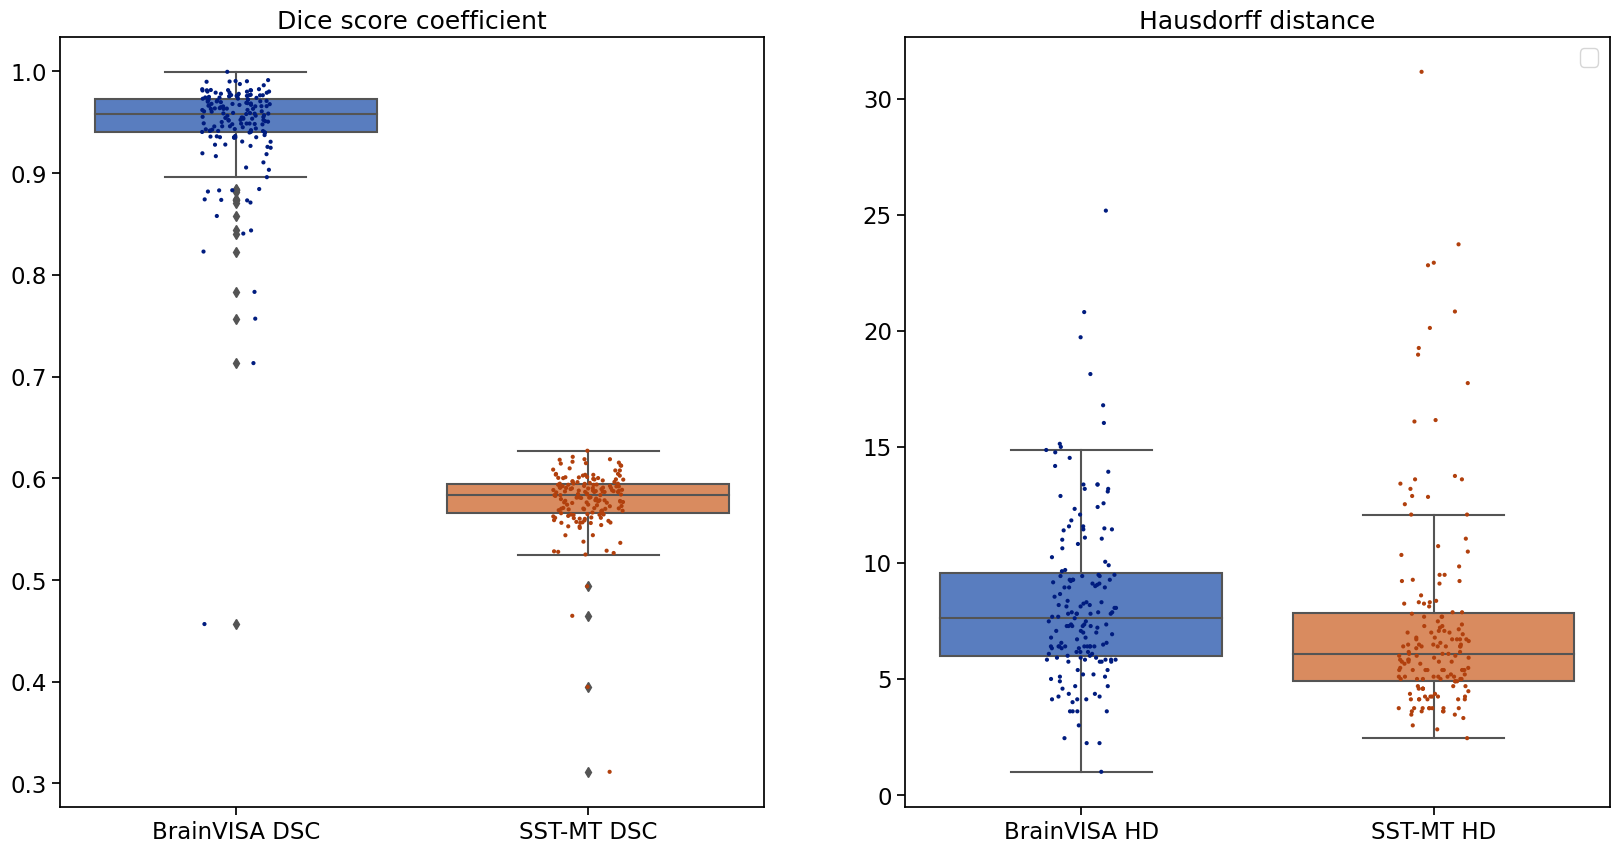

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(data=df[['BrainVISA DSC', 'SST-MT DSC']], orient='v', showfliers = True, ax=ax[0])
sns.stripplot(data=df[['BrainVISA DSC', 'SST-MT DSC']],
              size=3, ax=ax[0],dodge=True, palette='dark'
              )

sns.boxplot(data=df[['BrainVISA HD', 'SST-MT HD']], orient='v', showfliers = False, ax=ax[1])
sns.stripplot(data=df[['BrainVISA HD', 'SST-MT HD']],
              size=3, ax=ax[1],dodge=True, palette='dark'
              )

ax[0].set_title('Dice score coefficient')
ax[1].set_title('Hausdorff distance')
plt.legend()
# apply log scale
# plt.yscale('log')
plt.show()

In [11]:
df[df['SST-MT HD'] <= df['BrainVISA HD']]

,BrainVISA DSC,bvisa_iou,BrainVISA HD,SST-MT DSC,pred_iou,SST-MT HD
caseid,,,,,,
sub-via015,0.942288,0.890874,8.306624,0.579511,0.407966,5.830952
sub-via018,0.960474,0.923954,7.810250,0.587902,0.416332,7.141428
sub-via050,0.873230,0.774986,16.031220,0.556681,0.385695,13.747727
sub-via059,0.952381,0.909091,8.306624,0.593647,0.422118,5.000000
sub-via086,0.874221,0.776547,8.185353,0.560261,0.389140,6.782330
...,...,...,...,...,...,...
sub-via462,0.884390,0.792741,12.884099,0.597135,0.425654,4.123106
sub-via495,0.903306,0.823662,11.445523,0.600203,0.428779,4.242641
sub-via508,0.857888,0.751142,12.409674,0.594722,0.423206,7.071068


# Compare Volumes and SRF Areas

In [33]:
import trimesh

In [75]:
demo_via = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/VIA11_fmriflanker_info_database_2021jan25.xlsx')
demo_via['caseid'] = [f'sub-via{x:03d}' for x in demo_via['via_id'].values]
caseid_hand = {r['caseid']:r['group'] for i,r in demo_via.iterrows() if ~np.isnan(r['handedness'])}

In [34]:
mesh_paths = [x for x in Path('/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited').glob('**/*.ply')]
subj_meshes = []

for p in tqdm(mesh_paths):
     p = str(p)
     subj_id = p[p.find('sub-via'):p.find('sub-via')+10]
     side = 'L' if 'LSulci' in p else 'R'
     mesh = trimesh.load(p)
     volume = mesh.volume
     srfarea = mesh.area
     subj_meshes.append({'side':side, 'volume':volume, 'srfarea':srfarea, 'subj_id':subj_id})

100%|██████████| 331/331 [00:13<00:00, 25.45it/s]


In [82]:
subj_meshes = pd.DataFrame(subj_meshes)
assym_ratio = pd.DataFrame(subj_meshes.groupby('subj_id').apply(lambda x: (x[x['side']=='L']['volume'].values[0] / x[x['side']=='R']['volume'].values[0],
                                                                           x[x['side']=='L']['srfarea'].values[0] / x[x['side']=='R']['srfarea'].values[0])))
assym_ratio['Volume Asymmetry L/R'] = assym_ratio[0].apply(lambda x: x[0])
assym_ratio['Surface Area Assymetry L/R'] = assym_ratio[0].apply(lambda x: x[1])
assym_ratio['handedness'] = [caseid_hand[x] for x in assym_ratio.index.values]
assym_ratio.drop(0, axis=1, inplace=True)
# assym_ratio.loc[assym_ratio.handedness == 1,'handedness'] = 'Left Handed'
# assym_ratio.loc[assym_ratio.handedness == 2,'handedness'] = 'Ambidextrous'
# assym_ratio.loc[assym_ratio.handedness == 3,'handedness'] = 'Right Handed'

assym_ratio

,Volume Asymmetry L/R,Surface Area Assymetry L/R,handedness
subj_id,,,
sub-via003,1.014424,1.015841,3.0
sub-via004,1.097988,1.094163,3.0
sub-via005,0.949685,0.919406,3.0
sub-via010,1.097767,1.050237,2.0
sub-via013,1.018224,0.951722,3.0
...,...,...,...
sub-via511,0.877618,0.888657,3.0
sub-via512,0.976647,1.014557,3.0
sub-via518,1.050668,1.042143,3.0


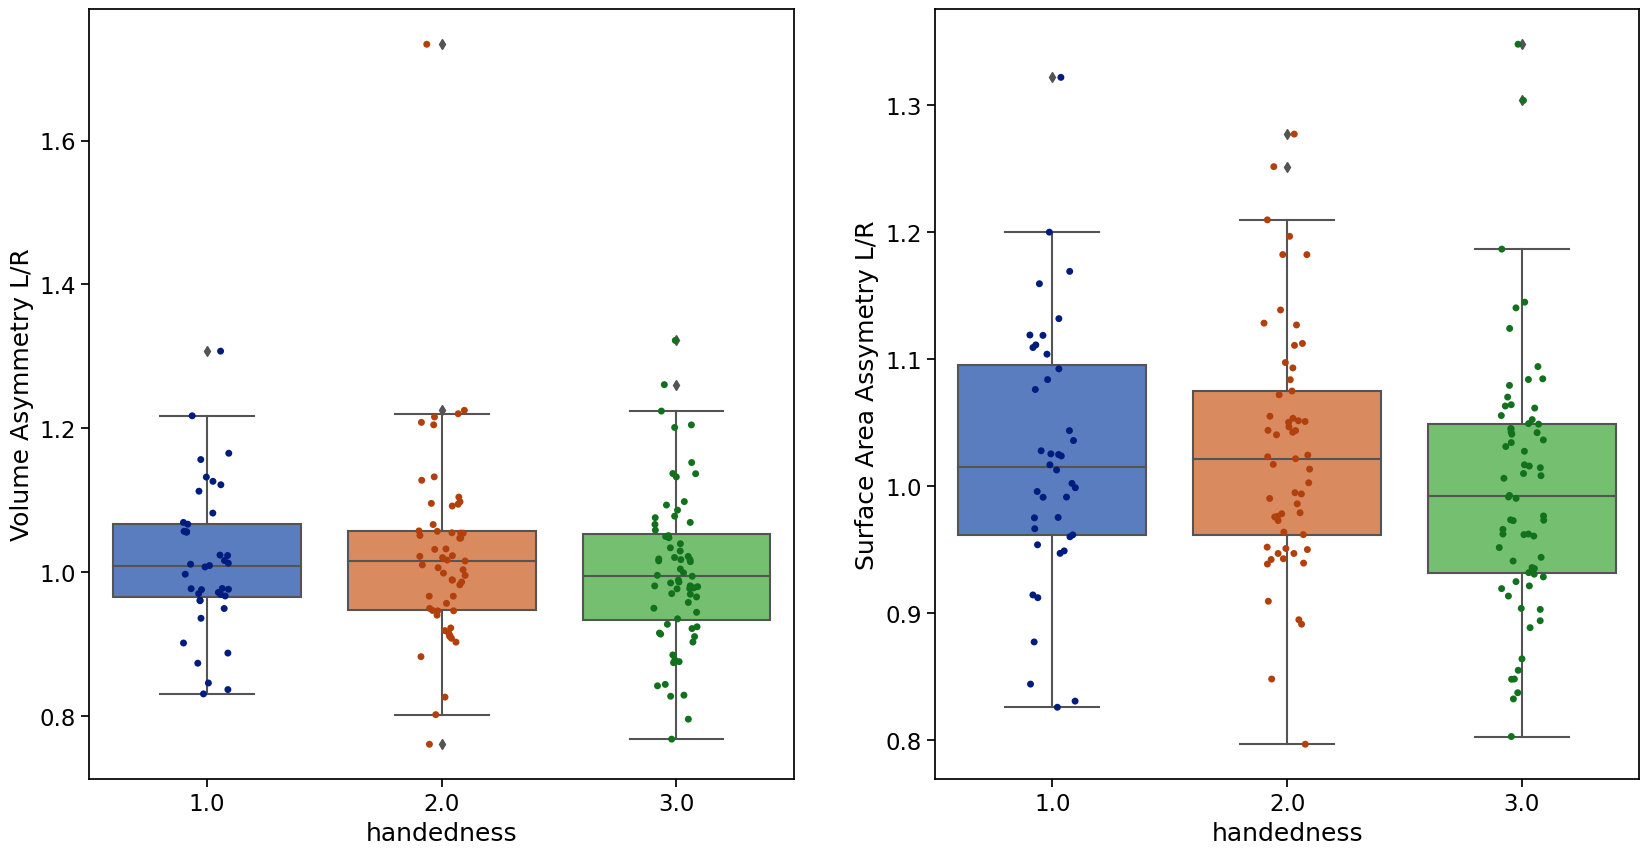

In [83]:
# plot assymetry ratio by handedness
sns.set_palette("muted")
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.boxplot(data=assym_ratio, x='handedness', y='Volume Asymmetry L/R', ax=ax[0])
sns.stripplot(data=assym_ratio, x='handedness', y='Volume Asymmetry L/R', ax=ax[0], dodge=True, palette='dark')

sns.boxplot(data=assym_ratio, x='handedness', y='Surface Area Assymetry L/R', ax=ax[1])
sns.stripplot(data=assym_ratio, x='handedness', y='Surface Area Assymetry L/R', ax=ax[1], dodge=True, palette='dark')
plt.show()

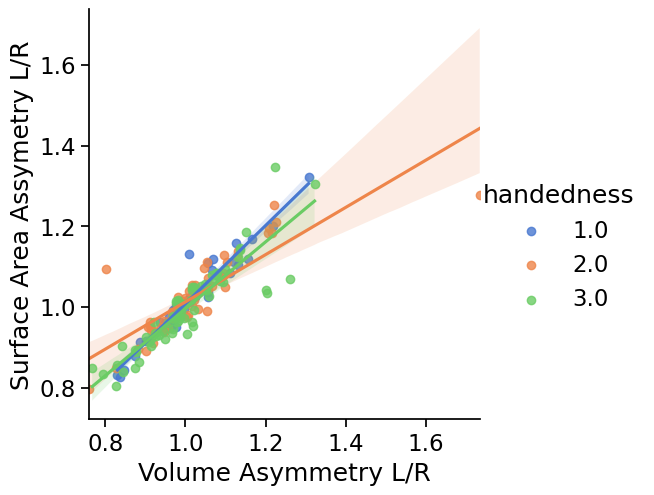

In [85]:
sns.lmplot(data=assym_ratio, x='Volume Asymmetry L/R', y='Surface Area Assymetry L/R', hue='handedness')

In [23]:
segmh_paths = [x for x in Path('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/correctes_res/predicted/segmentations').glob('*.nii.gz')]
save_path = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/correctes_res/predicted/segmentations')
from skimage.morphology import label, binary_dilation
from collections import Counter
def split_sulci(segm: np.ndarray):
    dil = segm[:, :, :]
    
    while len(np.unique((label(dil)))) > 3:
        dil = binary_dilation(dil)
    
    return label(dil)

In [58]:
# res = [ ]
# coords = []
# for s in tqdm(segmh_paths):
#     simg = sitk.GetArrayFromImage(sitk.ReadImage(str(s)))
#     simg = split_sulci(simg)
#     simg_lab = label(simg, connectivity=2)
    
#     lab1_loc = np.stack(np.where(simg==1), 1).mean(0)[2]
#     lab2_loc = np.stack(np.where(simg==2), 1).mean(0)[2]
    
#     leftest_lab = 1 if lab1_loc < lab2_loc else 2
#     rightest_lab = 2 if lab1_loc < lab2_loc else 1
    
#     Lsulc = sitk.GetImageFromArray((simg*((simg_lab == leftest_lab))).astype(np.int32))
#     Rsulc = sitk.GetImageFromArray((simg*((simg_lab == rightest_lab))).astype(np.int32))
    
#     sitk.WriteImage(Lsulc, str(save_path / f'Lsulc{s.name}'))
#     sitk.WriteImage(Rsulc, str(save_path / f'Rsulc{s.name}'))
    
#     coords.append([np.stack(np.where(simg==1), 1).mean(0),
#                    np.stack(np.where(simg==2), 1).mean(0)])
#     res.append(np.unique(simg_lab, return_counts=True))

100%|██████████| 165/165 [01:22<00:00,  1.99it/s]


In [87]:
import trimesh
from sklearn.metrics import   mean_squared_error

In [88]:
orig_rpath = '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/BrainVisa/CENTRE/SUBJECT/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_best/segmentation/RSulci_SUBJECT_default_session_best.ply'
orig_lpath = '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/BrainVisa/CENTRE/SUBJECT/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_best/segmentation/LSulci_SUBJECT_default_session_best.ply'

In [89]:
mesh_paths = [x for x in Path('/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited').glob('**/*.ply')]
subj_meshes = []

for p in tqdm(mesh_paths):
     p = str(p)
     subj_id = p[p.find('sub-via'):p.find('sub-via')+10]
     side = 'L' if 'LSulci' in p else 'R'
     site = 'DRCMR' if 'DRCMR' in p else 'CFIN'
     mesh = trimesh.load(p)
     volume = mesh.volume
     srfarea = mesh.area
     
     if side == 'R':
          orig_mesh = trimesh.load(orig_rpath.replace('SUBJECT', subj_id).replace('CENTRE', site))
     else:
          orig_mesh = trimesh.load(orig_lpath.replace('SUBJECT', subj_id).replace('CENTRE', site))
     
     orig_mesh_volume = orig_mesh.volume
     orig_mesh_srfarea = orig_mesh.area
     
     subj_meshes.append({'side':side,
                         'corrected_volume':volume, 'corrected_srfarea':srfarea,
                         'orig_mesh_volume':orig_mesh_volume, 'orig_mesh_srfarea':orig_mesh_srfarea,
                         'subj_id':subj_id})

100%|██████████| 331/331 [00:02<00:00, 116.39it/s]


In [90]:
subj_meshes = pd.DataFrame(subj_meshes)
subj_meshes

,side,corrected_volume,corrected_srfarea,orig_mesh_volume,orig_mesh_srfarea,subj_id
0,L,1205.096601,3323.551263,1273.673340,3519.454973,sub-via003
1,R,1187.961906,3271.723535,1312.088164,3645.684114,sub-via003
2,L,1228.228377,3354.827274,1254.378059,3422.097870,sub-via004
3,R,1118.617666,3066.114044,1130.345817,3096.115289,sub-via004
4,L,1176.058180,3224.295888,1234.440782,3415.113030,sub-via005
...,...,...,...,...,...,...
326,R,987.047862,2636.090311,970.623357,2633.984248,sub-via511
327,L,1220.225332,3300.219146,1219.910172,3307.029896,sub-via512
328,R,1249.402443,3252.867596,1230.614202,3256.118587,sub-via512
329,L,1215.497338,3244.348508,1248.338066,3384.465277,sub-via519


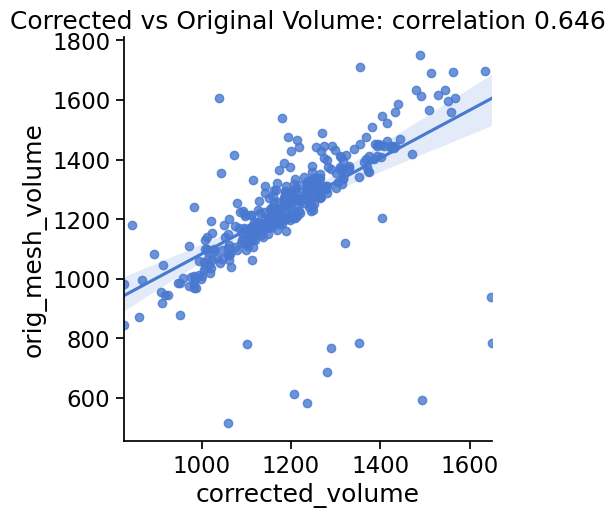

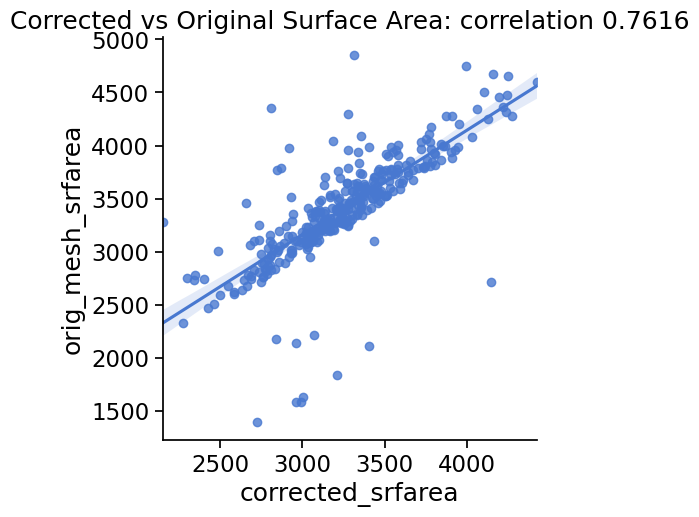

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,corrected_volume,corrected_srfarea,orig_mesh_volume,orig_mesh_srfarea
corrected_volume,1.000000,0.942774,0.646010,0.633434
corrected_srfarea,0.942774,1.000000,0.763335,0.761614
orig_mesh_volume,0.646010,0.763335,1.000000,0.994198
orig_mesh_srfarea,0.633434,0.761614,0.994198,1.000000


In [95]:

sns.lmplot(data=subj_meshes, x='corrected_volume', y='orig_mesh_volume', fit_reg=True)
plt.title(f'Corrected vs Original Volume: correlation {0.646}')
plt.show()
sns.lmplot(data=subj_meshes, x='corrected_srfarea', y='orig_mesh_srfarea', fit_reg=True)
plt.title(f'Corrected vs Original Surface Area: correlation {0.7616}')
plt.show()
subj_meshes.corr()


In [96]:
mp = '/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/correctes_res/brainvisa/meshes/sub-via003.ply'

In [99]:
mesh = trimesh.load(mp)

ValueError: PLY is unexpected length!